In [1]:
import os
import requests
import subprocess
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from typing import Callable
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from copy import deepcopy

RNG = torch.Generator().manual_seed(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'cuda'

In [2]:
torch.manual_seed(3047)

Gr = torch.Generator()
Gr.manual_seed(20)

Gf = torch.Generator()
Gf.manual_seed(30)

Gv = torch.Generator()
Gv.manual_seed(40)

In [3]:
## Code snippet to connect to the Kaggle model's pretrained original model weights 
# Mock setting

import logging
import requests
import tqdm
from torch.utils.data import Subset
from torchvision import transforms

USE_MOCK: bool = True

if USE_MOCK:
    logging.warning('Running with Mock')
    logging.warning('In this mode, internet access may be required.')

    n_checkpoints = 10

    mock_dir = './mock'
    mock_model_path = os.path.join(mock_dir, "weights_resnet18_cifar10.pth")
    os.makedirs(mock_dir, exist_ok=True)

In [4]:
local_path = "retrain_weights_resnet18_cifar10.pth"
if os.path.exists(local_path):
    os.remove(local_path)
response = requests.get("https://storage.googleapis.com/unlearning-challenge/" + local_path)
open(local_path, "wb").write(response.content)


44808169

In [5]:
weights_pretrained = torch.load(local_path, map_location=DEVICE)
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

100%|██████████| 170498071/170498071 [00:03<00:00, 46378237.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
def matching_grads(model, retain_loader, forget_loader):
    indices = torch.randperm(len(retain_loader.dataset), dtype=torch.int32, device='cpu')[:len(forget_loader.dataset)]
    retain_dataset = Subset(retain_loader.dataset, indices)
    retain_loader = DataLoader(retain_dataset, batch_size=64, shuffle=True)
    
    model.zero_grad()
    for (inputs, targets) in retain_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        
    for (inputs, targets) in forget_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = -F.cross_entropy(outputs, targets)
        loss.backward()

In [8]:
def set_layer(model, layer_name, layer):
    splited = layer_name.split('.')
    if len(splited) == 1:
        setattr(model, splited[0], layer)
    elif len(splited) == 3:
        setattr(getattr(model, splited[0])[int(splited[1])], splited[2], layer)
    elif len(splited) == 4:
        getattr(getattr(model, splited[0])[int(splited[1])], splited[2])[int(splited[3])] = layer

In [9]:
@torch.no_grad()
def re_init(model, px): # re init smallest gradients
    print("Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)")
    for name, m in list(model.named_modules()):
        if isinstance(m, nn.Conv2d):
            mask = torch.zeros_like(m.weight, device=DEVICE).bool()
            nparams_toprune = round(px*mask.nelement())
        
            out_c, in_c, ke, _ = mask.shape
            value = -m.weight.grad.abs()
            topk = torch.topk(value.view(-1), k=nparams_toprune)
            mask.view(-1)[topk.indices] = True
            grad_mask = mask.clone().float()
            grad_mask[grad_mask==0] += 0.1
            new_conv = deepcopy(m)
            new_conv.weight.data = grad_mask
            nn.init.kaiming_normal_(new_conv.weight, mode="fan_out", nonlinearity="relu")

            new_conv.weight.data[~mask] = m.weight[~mask]

            set_layer(model, name, new_conv)


In [10]:
def unlearning(
    net, 
    retain_loader, 
    forget_loader, 
    val_loader):

    matching_grads(net, retain_loader, forget_loader)
    re_init(net, init_rate)
    epochs = epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    net.train()

    for ep in range(epochs):
        for (inputs, targets) in retain_loader:
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, targets)
          
          loss.backward()
          optimizer.step()
    
        scheduler.step()
    net.eval()
    return net

In [11]:
def evaluation(net, dataloader, criterion, device = 'cuda'):
    net.eval()
    total_samp = 0
    total_acc = 0
    total_loss = 0.0
    for (images, labels) in dataloader:
        images, labels = images.to(device), labels.to(device)
        _pred = net(images)
        total_samp+=len(labels)
        #print(f'total_samp={total_samp}')
        loss = criterion(_pred, labels)
        total_loss += loss.item()
        total_acc+=(_pred.max(1)[1] == labels).float().sum().item()
        #print(f'total_acc={total_acc}')
    #print(f'total_sample={total_samp}')
    mean_loss = total_loss / len(dataloader)
    mean_acc = total_acc/total_samp
    print(f'loss={mean_loss}')
    print(f'acc={mean_acc}')
    return mean_acc, mean_loss

In [12]:
criterion = nn.CrossEntropyLoss()
# retain_loader, forget_loader, validation_loader = get_dataset(64)
print(f"Retain set accuracy: {100.0 * evaluation(rt_model, retain_loader, criterion)[0]:0.1f}%")
print(f"Forget set accuracy: {100.0 * evaluation(rt_model, forget_loader, criterion)[0]:0.1f}%")


loss=0.018128998776691416
acc=0.9952666666666666
Retain set accuracy: 99.5%
loss=0.47970081903040407
acc=0.882
Forget set accuracy: 88.2%


In [43]:
sch = 'cosine'  
init_rate = 0.25 
lr = 0.01 # 0.005  
epoch = 10  
weight_decay = 5e-4

In [14]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset,
            batch_size=loader.batch_size,
            shuffle=False,
            num_workers=loader.num_workers)

    all_outputs = []
    all_targets = []

    for (inputs, targets) in loader:
#         inputs, targets = sample["image"],sample["age_group"]
        inputs, targets = inputs.to(DEVICE), targets.to("cpu")

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)

        all_outputs.append(logits)
        all_targets.extend(targets)

    return np.array(all_targets), np.concatenate(all_outputs) # (len(loader.dataset), num_classes)


In [15]:
def cross_entropy_f(x, targets):
    # Convert NumPy array to PyTorch tensor
    x_tensor = torch.from_numpy(x)

    # Apply softmax to the model output
    x_softmax = F.softmax(x_tensor, dim=-1)

    # Convert targets to one-hot encoding
    targets_tensor = torch.from_numpy(targets)
    targets_one_hot = F.one_hot(targets_tensor, num_classes=x_tensor.shape[-1])

    # Avoiding NaN values in x
    x_tensor[torch.isnan(x_tensor)] = 0.0

    # Calculate cross-entropy loss for each example
    loss = -torch.sum(targets_one_hot * torch.log(x_softmax), dim=-1)

    # Convert the result back to a NumPy array if needed
    loss_np = loss.numpy()

    return loss_np


In [16]:
def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}

def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)

    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    has_nan = np.isnan(samples).any()
#     print(has_nan)

    samples = np.nan_to_num(samples, nan=0)

    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)

    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])

    return fpr, fnr


In [17]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example,
    given the FPRs and FNRs resulting from various attacks.

    The smaller epsilon is, the better the unlearning is.

    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example.
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)

    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))

    return np.nanmax(per_attack_epsilon)

def bin_index_fn(
        epsilons: np.ndarray,
        bin_width: float = 0.5,
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def H(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)


In [18]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the
      distribution of each model (N=512 in the case of the competition's leaderboard)
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """

    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape

    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"

    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")

        sample_fprs, sample_fnrs = [], []

        for attack in attacks:
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]

            fpr, fnr = attack(uls, rls)

            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)

        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)

    return H(np.array(epsilons))


In [20]:
from tqdm import tnrange, trange

In [21]:
## ## This snippet is taken is provided by the orgamnizers of kaggle competition as a startup script.

attacks = [logistic_regression_attack]
criterion = nn.CrossEntropyLoss()
outputs_U = []
outputs_R = []
retain_accuracy = []
test_accuracy = []
forget_accuracy = []

import numpy as np
if USE_MOCK:

    # NOTE: Almost same as the original codes

    # Download
    if not os.path.exists(mock_model_path):
        response = requests.get("https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth")
        open(mock_model_path, "wb").write(response.content)

    os.makedirs('/kaggle/tmp', exist_ok=True)
    net = resnet18(weights=None, num_classes=10)
    net.to(DEVICE)
    net.load_state_dict(torch.load(mock_model_path))
    u_model = deepcopy(net)
    for i in trange(n_checkpoints):
        net.load_state_dict(torch.load(mock_model_path))
        print("I am unlearning all the wrong things you taught me")
        u_model = unlearning(net, retain_loader, forget_loader, val_loader)
        state = u_model.state_dict()
        
        targets, outputs_Ui = compute_outputs(u_model, forget_loader)

        outputs_U.append( cross_entropy_f(outputs_Ui, targets) )

        print("Computing retain accuracy on Unlearning Model")
        acc, _ = evaluation(u_model, retain_loader, criterion)
        print("Retain accuracy on Unlearning Model is ",acc)
        retain_accuracy.append(acc)

        print("Computing test accuracy on Unlearning model")
        acc,_ = evaluation(u_model, val_loader, criterion)
        print("Test accuracy on Unlearning model is ", acc)
        test_accuracy.append(acc)

        print("Computing forget accuracy on Unlearning model")
        acc,_ = evaluation(u_model, forget_loader, criterion)
        print("Forget accuracy on Unlearning model is ",acc)
        forget_accuracy.append(acc)

    outputs_U = np.array(outputs_U)
    print("Printing outputs_U shape ",outputs_U.shape)

    assert outputs_U.shape == (n_checkpoints, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."


    RAR, _ = evaluation(rt_model, retain_loader, criterion)
    TAR, _ = evaluation(rt_model, val_loader, criterion)
    FAR, _ = evaluation(rt_model, forget_loader, criterion)
    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)

    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR

    for i in range(n_checkpoints):
        targets, outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10)

        outputs_R.append(cross_entropy_f(outputs_Ri, targets) )

    outputs_R = np.array(outputs_R)
    print("Printing outputs_R shape ",outputs_R.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0015667029967351648
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5693370804190636
acc=0.858
Test accuracy on Unlearning model is  0.858
Computing forget accuracy on Unlearning model


 10%|█         | 1/10 [02:36<23:25, 156.13s/it]

loss=0.30529535803943875
acc=0.9104
Forget accuracy on Unlearning model is  0.9104
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0015034779627802147
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5910104863345623
acc=0.8602
Test accuracy on Unlearning model is  0.8602
Computing forget accuracy on Unlearning model


 20%|██        | 2/10 [05:12<20:50, 156.26s/it]

loss=0.2908059474080801
acc=0.9104
Forget accuracy on Unlearning model is  0.9104
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0015078661802941826
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5763582676649094
acc=0.8568
Test accuracy on Unlearning model is  0.8568
Computing forget accuracy on Unlearning model


 30%|███       | 3/10 [07:48<18:13, 156.22s/it]

loss=0.2871267642825842
acc=0.9134
Forget accuracy on Unlearning model is  0.9134
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0015542740463636371
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5796781584620476
acc=0.8578
Test accuracy on Unlearning model is  0.8578
Computing forget accuracy on Unlearning model


 40%|████      | 4/10 [10:24<15:37, 156.20s/it]

loss=0.3028412342071533
acc=0.9116
Forget accuracy on Unlearning model is  0.9116
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0015055694946733472
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.6003858715295791
acc=0.8526
Test accuracy on Unlearning model is  0.8526
Computing forget accuracy on Unlearning model


 50%|█████     | 5/10 [13:01<13:01, 156.22s/it]

loss=0.302318031527102
acc=0.9102
Forget accuracy on Unlearning model is  0.9102
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0014383976059351962
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5830905683338642
acc=0.8646
Test accuracy on Unlearning model is  0.8646
Computing forget accuracy on Unlearning model


 60%|██████    | 6/10 [15:37<10:25, 156.26s/it]

loss=0.3053490351885557
acc=0.9088
Forget accuracy on Unlearning model is  0.9088
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0015045385007397272
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5933662876486778
acc=0.856
Test accuracy on Unlearning model is  0.856
Computing forget accuracy on Unlearning model


 70%|███████   | 7/10 [18:13<07:48, 156.21s/it]

loss=0.3060651822161162
acc=0.9068
Forget accuracy on Unlearning model is  0.9068
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.001462009314226717
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5732584601268172
acc=0.8562
Test accuracy on Unlearning model is  0.8562
Computing forget accuracy on Unlearning model


 80%|████████  | 8/10 [20:49<05:12, 156.21s/it]

loss=0.32089688815176487
acc=0.9096
Forget accuracy on Unlearning model is  0.9096
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0014756670286508531
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5745837923139334
acc=0.8538
Test accuracy on Unlearning model is  0.8538
Computing forget accuracy on Unlearning model


 90%|█████████ | 9/10 [23:25<02:36, 156.22s/it]

loss=0.2925214936025441
acc=0.9098
Forget accuracy on Unlearning model is  0.9098
I am unlearning all the wrong things you taught me
Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Computing retain accuracy on Unlearning Model
loss=0.0014268435727651442
acc=1.0
Retain accuracy on Unlearning Model is  1.0
Computing test accuracy on Unlearning model
loss=0.5803392887115478
acc=0.8594
Test accuracy on Unlearning model is  0.8594
Computing forget accuracy on Unlearning model


100%|██████████| 10/10 [26:02<00:00, 156.27s/it]

loss=0.32526463028043506
acc=0.9074
Forget accuracy on Unlearning model is  0.9074
Printing outputs_U shape  (10, 5000)


loss=0.0181210064878211
acc=0.9952666666666666
loss=0.47614343613386156
acc=0.8798
loss=0.45444367872551084
acc=0.882
Printing outputs_R shape  (10, 5000)


In [22]:
from tqdm import tqdm

attacks = [logistic_regression_attack]

f = forgetting_quality(
outputs_U,
outputs_R,
attacks=attacks,
delta=0.01)

ret = {
    "total_score": f * RA_ratio * TA_ratio,
    "F": f,
    "unlearn_retain_accuracy": RAU,
    "unlearn_test_accuracy": TAU,
    "unlearn_forget_accuracy": FAU,
    "retrain_retain_accuracy": RAR,
    "retrain_test_accuracy": TAR,
    "retrain_forget_accuracy": FAR,
    "retrain_outputs": outputs_R,
    "unlearn_outputs": outputs_U,
    "unlearning_model": u_model
}


Computing F...: 100%|██████████| 5000/5000 [00:35<00:00, 142.78it/s]


In [23]:
ret

{'total_score': 0.7046001934137662,
 'F': 0.719468505859375,
 'unlearn_retain_accuracy': 1.0,
 'unlearn_test_accuracy': 0.85754,
 'unlearn_forget_accuracy': 0.9098400000000002,
 'retrain_retain_accuracy': 0.9952666666666666,
 'retrain_test_accuracy': 0.8798,
 'retrain_forget_accuracy': 0.882,
 'retrain_outputs': array([[1.1427273e+00, 6.8272422e-03, 5.4480130e-05, ..., 1.4155467e-01,
         4.6083114e-01, 2.1786564e-03],
        [1.1427273e+00, 6.8272422e-03, 5.4480130e-05, ..., 1.4155467e-01,
         4.6083114e-01, 2.1786564e-03],
        [1.1427273e+00, 6.8272422e-03, 5.4480130e-05, ..., 1.4155467e-01,
         4.6083114e-01, 2.1786564e-03],
        ...,
        [1.1427273e+00, 6.8272422e-03, 5.4480130e-05, ..., 1.4155467e-01,
         4.6083114e-01, 2.1786564e-03],
        [1.1427273e+00, 6.8272422e-03, 5.4480130e-05, ..., 1.4155467e-01,
         4.6083114e-01, 2.1786564e-03],
        [1.1427273e+00, 6.8272422e-03, 5.4480130e-05, ..., 1.4155467e-01,
         4.6083114e-01, 2.1786

In [24]:
ut_model = ret["unlearning_model"]
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


ut_train_losses = compute_losses(ut_model, train_loader)
ut_test_losses = compute_losses(ut_model, test_loader)
ut_forget_losses = compute_losses(ut_model, forget_loader)


In [25]:
rt_train_losses = compute_losses(rt_model, train_loader)
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)


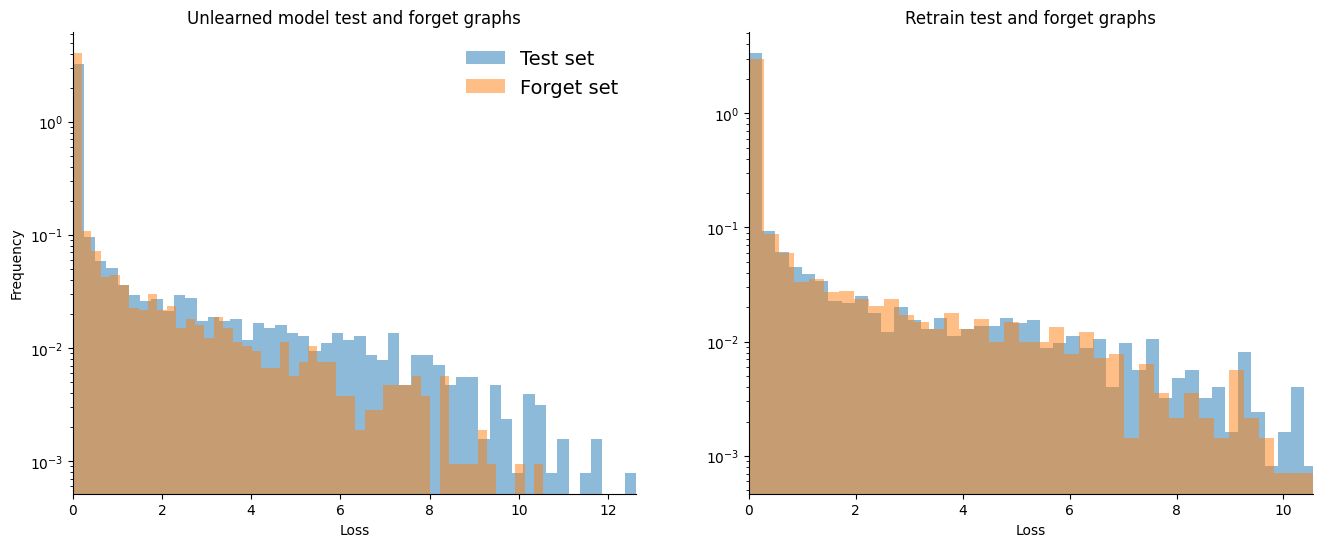

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model test and forget graphs")
ax1.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Retrain test and forget graphs"
)
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

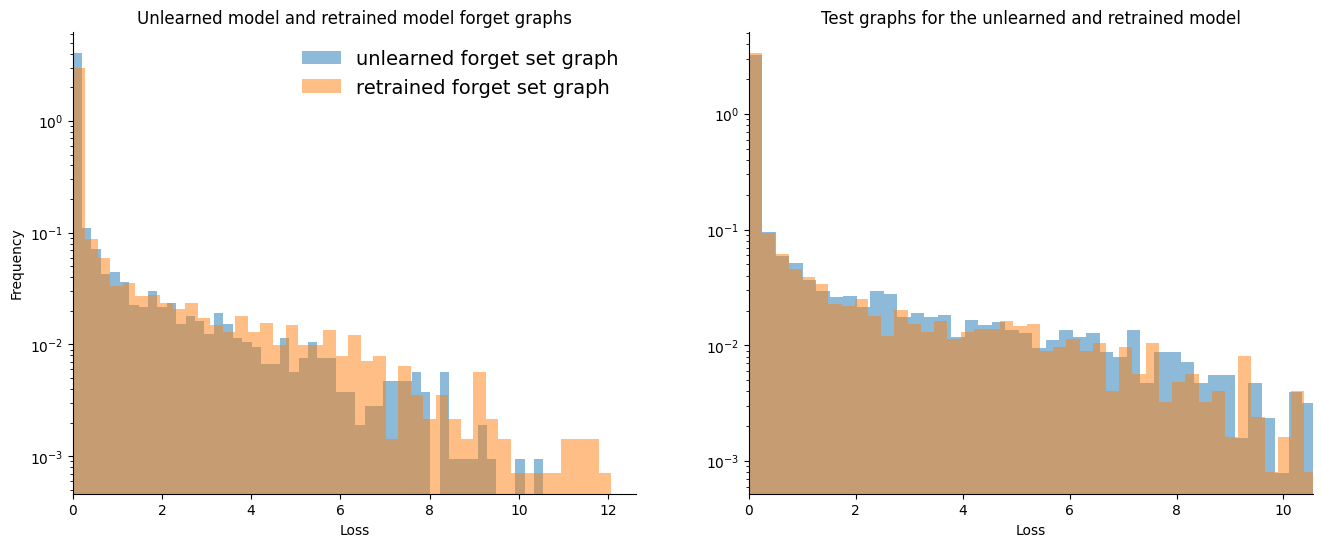

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model and retrained model forget graphs")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="unlearned forget set graph")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="retrained forget set graph")

ax2.set_title(
    f"Test graphs for the unlearned and retrained model"
)
ax2.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()
